# Dissecting Spotify Valence

Assignment 3

---

> Odyssefs Diamantopoulos Pantaleon, Undergraduate Student <br />
> Department of Computer Science<br />
> Athens University of Economics and Business <br />
> p3180049@aueb.gr

## Q0: Importing the Data

 In order to get the data from Spotify I am going to follow step by step the "spotify_anova.ipynb" that was shown in class until the point where we form the dataframe containing all the necessary information.

* As I am going the same process I am going to explain every step

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

* Firstly I need to download the Chart zip from the https://zenodo.org/record/4778563#.Yg-Xy8lByUk website

* This zip contains chart data from global and regional markets from January 2017 to December 2019, considering eight of the top 10 music markets

* I am going to read all the csv's inside that folder and then load them all to one dataframe

In [2]:
header = 0
dfs = []
for file in glob.glob('Charts/*/201?/*.csv'):
    region = file.split('/')[-1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
196,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
197,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
198,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...


* Lets check how many unique songs exist in this dataset

In [3]:
len(all_charts['song_id'].unique())

13880

* Now I am going to get the audio features of each song in this dataset and store it in another dataframe

* In order to do this I had to first log in the Spotify for Developers website(https://developer.spotify.com/dashboard/login) and create a new project

* From there I got the known and secret id that gives us permission to download

* To download the correct song audio features we use the unique song ids that we have in the dataset as a key

In [4]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id='e15bfd4ec6594920bb88aca1af63193f', client_secret='18252a654ab34a35a09bfdf4867264c4')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [5]:
features = {}
all_track_ids = list(all_charts['song_id'].unique())

* Spotify allows us to get 100 song audio features at a time. Consequently, to get all 13880 we have to iterate

In [6]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

* Checking that we got the audio features for all of our songs

In [7]:
len(features)

13880

* Features now contain a song_id to audio_features connection

* As we can see each song has 12 distinct audio features and the valence feature that we are going to be studying

In [8]:
features['7qiZfU4dY1lWllzX7mPBI3']

{'danceability': 0.825,
 'energy': 0.652,
 'key': 1,
 'loudness': -3.183,
 'mode': 0,
 'speechiness': 0.0802,
 'acousticness': 0.581,
 'instrumentalness': 0,
 'liveness': 0.0931,
 'valence': 0.931,
 'tempo': 95.977,
 'type': 'audio_features',
 'id': '7qiZfU4dY1lWllzX7mPBI3',
 'uri': 'spotify:track:7qiZfU4dY1lWllzX7mPBI3',
 'track_href': 'https://api.spotify.com/v1/tracks/7qiZfU4dY1lWllzX7mPBI3',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7qiZfU4dY1lWllzX7mPBI3',
 'duration_ms': 233713,
 'time_signature': 4}

* Now I am going to create a dataframe from the feature dictionary 

In [9]:
tracks = pd.DataFrame.from_dict(features, orient='index')
tracks.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.1650,0.000003,0.134,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.4060,0.000000,0.180,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.4140,0.000000,0.111,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.0631,0.000013,0.325,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.0604,0.000611,0.159,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4


* Now I am going to remove song_id from an index and place it as a column

In [10]:
tracks = tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
tracks.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.681,0.594,7,-7.028,1,0.2820,0.1650,0.000003,0.134,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
1,0.720,0.763,9,-4.068,0,0.0523,0.4060,0.000000,0.180,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
2,0.748,0.524,8,-5.599,1,0.0338,0.4140,0.000000,0.111,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3,0.735,0.451,0,-8.374,1,0.0585,0.0631,0.000013,0.325,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
4,0.670,0.838,0,-4.031,1,0.0362,0.0604,0.000611,0.159,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4


* Here I am checking that all the column types make sense and there is no need for a change

In [11]:
print(tracks.dtypes)

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
song_id              object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
dtype: object


## Q1: Expore which Features Influence Valence

* We can now check for the correlation of the audio features with valence in our sample

* Inferential statistics can help to determine strength of relationship within a sample

* According to http://www.bwgriffin.com/gsu/courses/edur7130/content/descriptive_and_inferential_stat.htm there are specific types of Inferential statistics that we can use

* Since we have one sample and we want to find the relationships of the variables within it I am going to use the Pearson method 

In [12]:
trackcorr = tracks.corr(method='pearson') #Default method is Pearson
trackcorr.style.background_gradient(cmap='hot')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,0.005115,0.003732,0.060467,-0.114625,0.161106,-0.119502,-0.066644,-0.143246,0.239886,-0.023205,-0.199665,0.108085
energy,0.005115,1.000000,0.015910,0.732895,-0.027694,-0.022990,-0.421489,-0.041255,0.174463,0.367636,0.096416,0.017678,0.097628
key,0.003732,0.015910,1.000000,-0.008047,-0.179343,0.017855,0.010088,-0.003647,-0.006825,0.043517,-0.010224,-0.007012,-0.007540
loudness,0.060467,0.732895,-0.008047,1.000000,0.024081,-0.112223,-0.379965,-0.113044,0.113268,0.269421,0.072794,0.002782,0.104035
mode,-0.114625,-0.027694,-0.179343,0.024081,1.000000,-0.094801,-0.027133,0.014211,0.076738,-0.035945,0.018475,0.044004,-0.017882
speechiness,0.161106,-0.022990,0.017855,-0.112223,-0.094801,1.000000,0.009084,-0.066705,-0.028728,-0.025020,0.064061,-0.095025,0.055345
acousticness,-0.119502,-0.421489,0.010088,-0.379965,-0.027133,0.009084,1.000000,0.028519,0.006835,-0.026301,-0.073606,-0.035983,-0.097920
instrumentalness,-0.066644,-0.041255,-0.003647,-0.113044,0.014211,-0.066705,0.028519,1.000000,0.005769,-0.073128,-0.002244,0.080177,-0.040543
liveness,-0.143246,0.174463,-0.006825,0.113268,0.076738,-0.028728,0.006835,0.005769,1.000000,0.079136,0.032904,-0.018008,0.006338
valence,0.239886,0.367636,0.043517,0.269421,-0.035945,-0.025020,-0.026301,-0.073128,0.079136,1.000000,0.050688,-0.117293,0.052428


* Based on the correlation of the variables we see that the variables with high enough correlation to be considered impactful towards valence are mainly loudness, energy and danceability.

In [13]:
df = tracks[['loudness','energy','danceability','valence','song_id']].copy()

In [14]:
df.head(5)

,loudness,energy,danceability,valence,song_id
0,-7.028,0.594,0.681,0.5350,5aAx2yezTd8zXrkmtKl66Z
1,-4.068,0.763,0.720,0.7420,5knuzwU65gJK7IF5yJsuaW
2,-5.599,0.524,0.748,0.6610,7BKLCZ1jbUBVqRi2FVlTVw
3,-8.374,0.451,0.735,0.0862,3NdDpSvN911VPGivFlV5d0
4,-4.031,0.838,0.670,0.7170,78rIJddV4X0HkNAInEcYde


* I am also going to perform an anova test in order to see which features the anova test considers impactful

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anovamodel = ols("valence ~ danceability + energy + key + loudness + mode + speechiness + instrumentalness + liveness + tempo", data = tracks).fit()
aov_table = sm.stats.anova_lm(anovamodel, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
danceability,39.159108,1.0,1066.722321,1.751018e-225
energy,42.715155,1.0,1163.591593,5.704973e-245
key,0.891430,1.0,24.283188,8.412172e-07
loudness,0.741575,1.0,20.201051,7.027903e-06
mode,0.002866,1.0,0.078072,7.799319e-01
speechiness,2.695663,1.0,73.431816,1.150688e-17
instrumentalness,1.582851,1.0,43.117989,5.337076e-11
liveness,1.603176,1.0,43.671663,4.025340e-11
tempo,0.417844,1.0,11.382381,7.434701e-04
Residual,509.164210,13870.0,NaN,NaN


As we can see, the anova test agrees on the most part with the pearson test, since both consider danceability and energy as variables that severly imparct valence. However, the anova test places more value on speechiness than in loudness.

## Q2: Predict Valence

Before doing anything we have to prepare the data:

* More specifically, we need to put the audio features in a new dataframe and then separate the independent variables from the dependent variable(X , y accordingly)

* Then we are going to use the MinMaxScaler to normalize the independent variables value

* Finally, we are going to split the data in 80/20 training/test dataset

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

audio_feats = tracks[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','tempo','duration_ms','time_signature','valence']].copy()

X = audio_feats[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','tempo','duration_ms','time_signature']]
y = audio_feats['valence']

minmax = MinMaxScaler()
#Normalizing X values
X = minmax.fit_transform(X)
                 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)
feature_names = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','tempo','duration_ms','time_signature']


* I am going to create two lists that are going to contain the results for r2score and absolute mean error of each machine learning method used here

In [17]:
r2scoreval = []
abserrorval = []

### Linear regression

In order to find the best hyperparameters I am going to use GridSearchCV in order to test all the different values that the parameters can take. What GridSearchCV does is check how every possible parameter combination is performing on all the dataset. 

* I am also going to use 5 fold cross validation method

* In the gridsearch_support dictionary I have the parameter names and the values that I want GridSearchCV to check

In [18]:
gridsearch_support = {'fit_intercept' : ['True','False']   }

In [19]:
regressor = LinearRegression()
gs = GridSearchCV(estimator=regressor,param_grid=gridsearch_support,n_jobs=3,cv = 5,scoring="r2")

models = gs.fit(X_train,y_train)
print(models.best_params_)

{'fit_intercept': 'True'}


* After evaluating all possible parameter combinations, I pick the combination that did the best and perform the r2_score and mean absolute error metrics on it

In [20]:
bestmodellinear = models.best_estimator_
y_pred = bestmodellinear.predict(X_test)
score = r2_score(y_test,y_pred)
print(score)

0.24126705905767187


In [21]:
error = mean_absolute_error(y_test,y_pred)
print(error)

0.15124453011445543


* Then I am going to get the coefficients that indicate how important was each feature and plot them

Feature: danceability, Score: 0.34790
Feature: energy, Score: 0.59499
Feature: key, Score: 0.02293
Feature: loudness, Score: -0.07810
Feature: mode, Score: 0.00549
Feature: speechiness, Score: -0.10606
Feature: acousticness, Score: 0.17193
Feature: instrumentalness, Score: -0.13008
Feature: liveness, Score: 0.03997
Feature: tempo, Score: 0.04556
Feature: duration_ms, Score: -0.31952
Feature: time_signature, Score: -0.00169


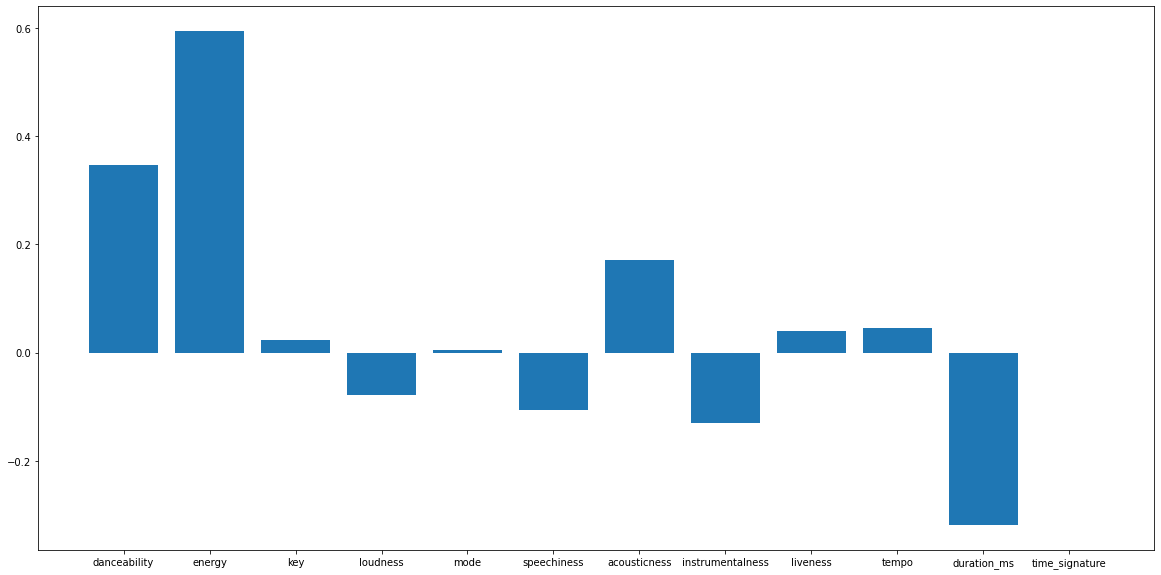

In [22]:
importancelinear = bestmodellinear.coef_

# summarize feature importance
for i,v in enumerate(importancelinear):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
fig = plt.figure(figsize = (20, 10))
plt.bar(feature_names, importancelinear)
plt.show()

* The size of the coefficients indicates how big is the impact of the independent variables on the dependent variable, while the sign shows the direction of the effect

* In this we see that in linear regression the variables that are most impactful are danceability, energy and the duration

* Finally, I am putting the results in the lists in order to vizualize them in the end

In [23]:
r2scoreval.append(score)
abserrorval.append(error)

### XGBooster algorithm

I am doing exactly the same thing for this method too, with the exception that I am going to use RandomizedSearchCV, because it is not as an exhaustive method(does not try out all the possible parameter values) and thus its quicker. The number of parameter combinations that are going to be checked are defined by n_iter which is going to be 10.

In [24]:
import xgboost as xgb

In [25]:
gridsearch_support = {'booster': ['gbtree', 'gblinear', 'dart'],
                        'colsample_bytree': [0.6, 0.7, 0.8],
                        'gamma': [0.0, 0.1, 0.2],
                        'learning_rate': [0.01, 0.02, 0.03, 0.04],
                        'max_depth': [3, 4, 5, 10],
                        'min_child_weight': [1, 2, 3, 4, 5]}

In [26]:
xgbregressor = xgb.XGBRegressor()
gs = RandomizedSearchCV(estimator = xgbregressor, param_distributions = gridsearch_support, n_iter = 10, cv = 5, n_jobs = 3, scoring = "r2")
models = gs.fit(X_train, y_train)
print(models.best_params_)

{'min_child_weight': 2, 'max_depth': 10, 'learning_rate': 0.04, 'gamma': 0.2, 'colsample_bytree': 0.6, 'booster': 'dart'}


In [27]:
bestmodelxgb = models.best_estimator_
y_pred = bestmodelxgb.predict(X_test)
score = r2_score(y_test,y_pred)
print(score)

0.33770681565696137


In [28]:
error = mean_absolute_error(y_test,y_pred)
print(error)

0.14093296415357492


* Now I am going to get the coefficients that indicate how important was each feature and plot them

Feature: danceability, Score: 0.12514
Feature: energy, Score: 0.19489
Feature: key, Score: 0.05862
Feature: loudness, Score: 0.09412
Feature: mode, Score: 0.06235
Feature: speechiness, Score: 0.06568
Feature: acousticness, Score: 0.07638
Feature: instrumentalness, Score: 0.06901
Feature: liveness, Score: 0.07738
Feature: tempo, Score: 0.06040
Feature: duration_ms, Score: 0.06669
Feature: time_signature, Score: 0.04933


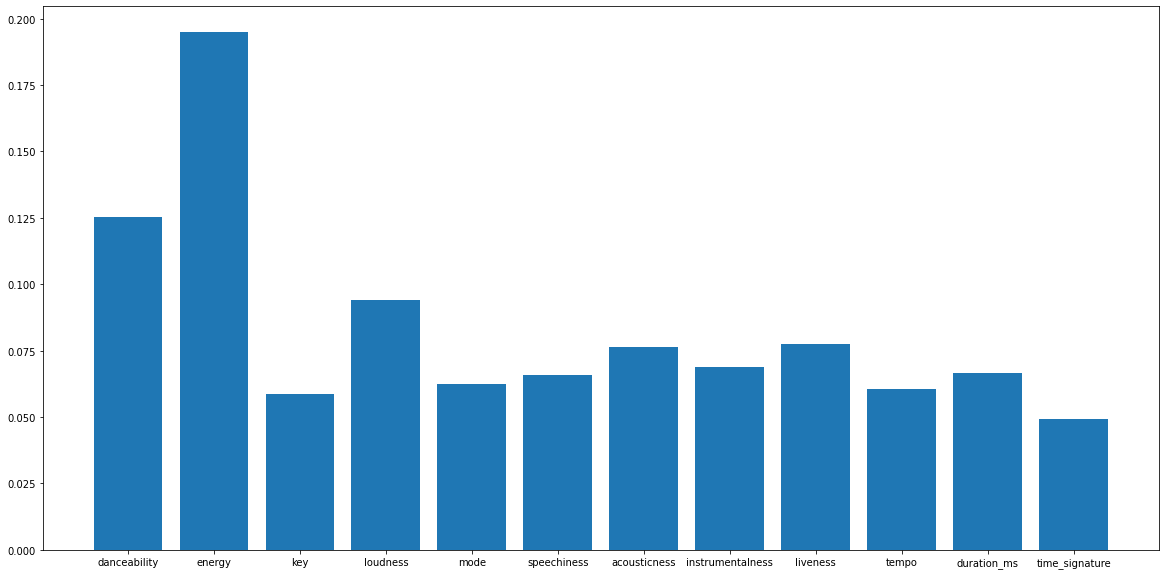

In [29]:
importancexgb = bestmodelxgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importancexgb):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
fig = plt.figure(figsize = (20, 10))
plt.bar(feature_names, importancexgb)
plt.show()

* In XGBoost we see that danceability, energy and loudness impact more the valence

In [30]:
r2scoreval.append(score)
abserrorval.append(error)

### Decision Tree regression

I am again using RandomizedSearchCV with n_iter=10

In [31]:
from sklearn.tree import DecisionTreeRegressor 

In [32]:
gridsearch_support = { 'criterion' : ['squared_error','friedman_mse','absolute_error','poisson'],
                      'splitter' : ['best','random'],
                      'max_depth' : [5,10,20,50,100],
                      'min_samples_split' : [2,3,4,5]
}

In [33]:
randomd = DecisionTreeRegressor()

gs = RandomizedSearchCV(estimator=randomd,param_distributions=gridsearch_support,n_iter=10,n_jobs=3,cv = 5,scoring="r2")

models = gs.fit(X_train,y_train)
print(models.best_params_)

{'splitter': 'best', 'min_samples_split': 3, 'max_depth': 5, 'criterion': 'squared_error'}


In [34]:
bestmodeldec = models.best_estimator_
y_pred = bestmodeldec.predict(X_test)
score = r2_score(y_test,y_pred)
print(score)

0.1857945528200402


In [35]:
error = mean_absolute_error(y_test,y_pred)
print(error)

0.15791388168951448


* Now I am going to get the coefficients that indicate how important was each feature and plot them

Feature: danceability, Score: 0.22315
Feature: energy, Score: 0.54178
Feature: key, Score: 0.00000
Feature: loudness, Score: 0.00839
Feature: mode, Score: 0.00000
Feature: speechiness, Score: 0.01317
Feature: acousticness, Score: 0.03906
Feature: instrumentalness, Score: 0.03491
Feature: liveness, Score: 0.07146
Feature: tempo, Score: 0.01353
Feature: duration_ms, Score: 0.05457
Feature: time_signature, Score: 0.00000


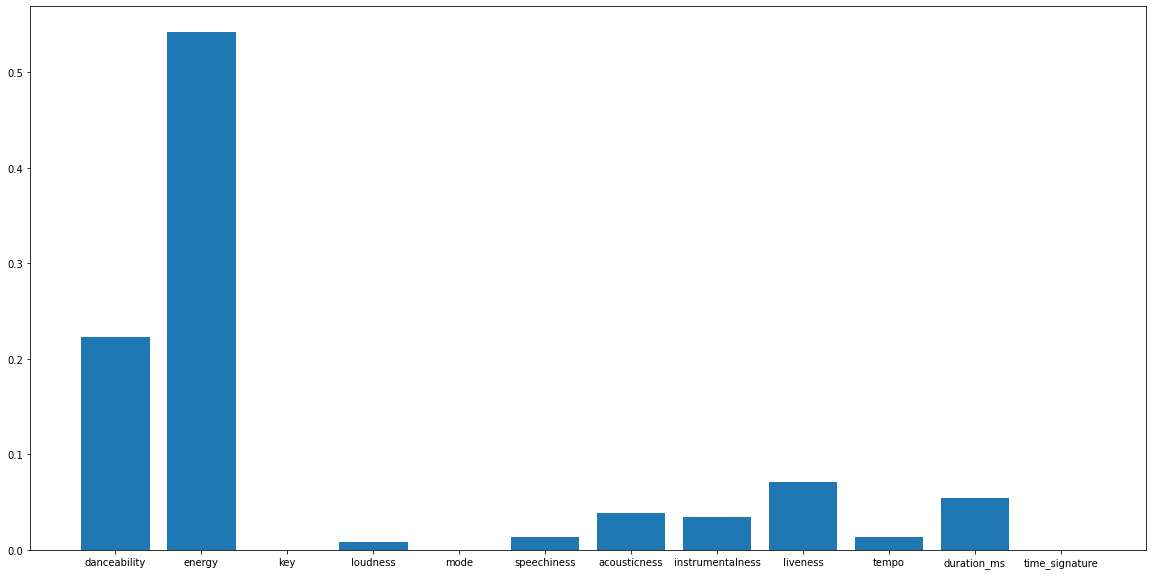

In [36]:
importancedt = bestmodeldec.feature_importances_
# summarize feature importance
for i,v in enumerate(importancedt):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
fig = plt.figure(figsize = (20, 10))
plt.bar(feature_names, importancedt)
plt.show()

* In Decision Trees danceability and energy are impacting valence

In [37]:
r2scoreval.append(score)
abserrorval.append(error)

### Random Forest regression

I am again using RandomizedSearchCV with n_iter=10

In [38]:
gridsearch_support = { 'n_estimators' : [20,50,100],
                      'criterion' : ['squared_error','friedman_mse','absolute_error','poisson'],
                      'max_features' : ['auto','sqrt','log2'],
                      'max_depth' : [5,10,20,50,100],
                      'min_samples_split' : [2,3,4,5]
}

In [39]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import plot_tree

randomf = RandomForestRegressor()

gs = RandomizedSearchCV(estimator=randomf,param_distributions=gridsearch_support,n_iter=10,n_jobs=3,cv = 5,scoring="r2")

models = gs.fit(X_train,y_train)
print(models.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'absolute_error'}


In [40]:
bestmodelrf = models.best_estimator_
y_pred = bestmodelrf.predict(X_test)
score = r2_score(y_test,y_pred)
print(score)

0.38423797646392066


* Now I am going to get the coefficients that indicate how important was each feature and plot them

Feature: danceability, Score: 0.12522
Feature: energy, Score: 0.14697
Feature: key, Score: 0.05471
Feature: loudness, Score: 0.11326
Feature: mode, Score: 0.01478
Feature: speechiness, Score: 0.09533
Feature: acousticness, Score: 0.10098
Feature: instrumentalness, Score: 0.05030
Feature: liveness, Score: 0.09774
Feature: tempo, Score: 0.09538
Feature: duration_ms, Score: 0.09797
Feature: time_signature, Score: 0.00736


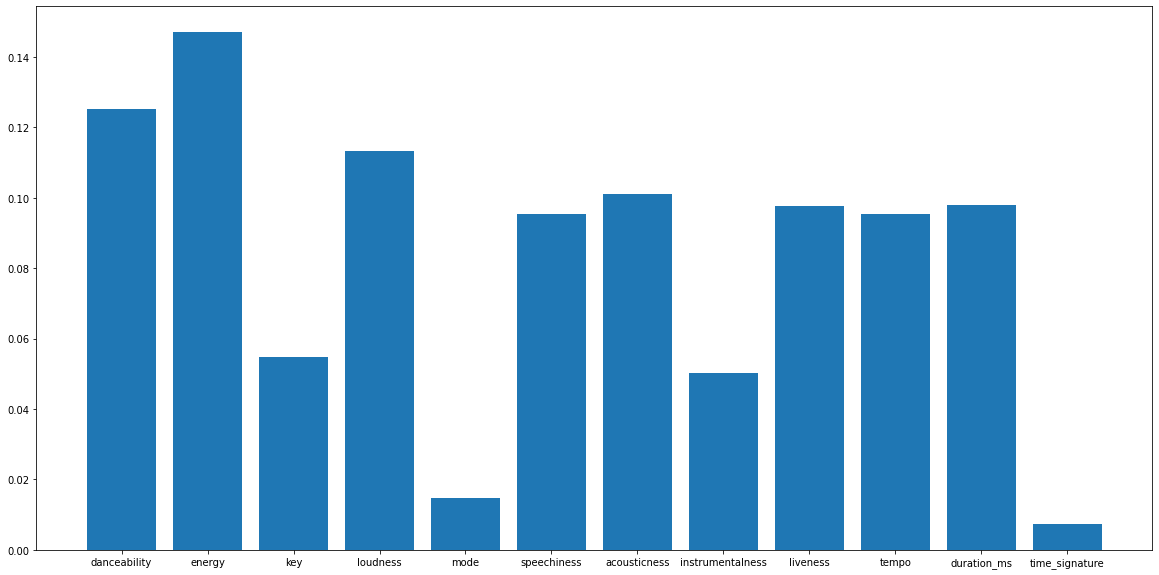

In [41]:
importancerf = bestmodelrf.feature_importances_
# summarize feature importance
for i,v in enumerate(importancerf):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
fig = plt.figure(figsize = (20, 10))
plt.bar(feature_names, importancerf)
plt.show()

* In Random Forest danceability and energy are again the main influence of the valence variable

In [42]:
error = mean_absolute_error(y_test,y_pred)
print(error)

0.13244808897694524


In [43]:
r2scoreval.append(score)
abserrorval.append(error)

### Neural Network -- Multi Layered Perceptron

I am going to create two Multi Layered Percepton Networks

In [44]:
from sklearn.neural_network import MLPRegressor

* The first one is going to use an already created library of sk_learn

* I am going to perform RandomizedSearchCV on it in order to find the best hyperparameters

* I am also going to try different number of hidden layers with different neurons in each hidden layer to see which one is better

In [45]:
gridsearch_support = { 'activation' : ['identity','logistic','tanh','relu'],
                      'solver' : ['lbfgs','sgd','adam'],
                      'learning_rate' : ['constant','invscaling','adaptive'],
                      'hidden_layer_sizes' : [(100,100,100,),(200,200,200,),(300,300,300),(100,100,100,100),(200,200,200,200),(300,300,300,300),]
}

In [46]:
neuralnetwork = MLPRegressor()

gs = RandomizedSearchCV(estimator=neuralnetwork,param_distributions=gridsearch_support,n_iter=10,n_jobs=3,cv = 5,scoring="r2")

models = gs.fit(X_train,y_train)
print(models.best_params_)

{'solver': 'lbfgs', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100, 100, 100), 'activation': 'tanh'}


In [47]:
bestmodelmlp = models.best_estimator_
y_pred = bestmodelmlp.predict(X_test)
score = r2_score(y_test,y_pred)
print(score)

0.24848044294193905


In [48]:
error = mean_absolute_error(y_test,y_pred)
print(error)

0.15062803650811551


In [49]:
r2scoreval.append(score)
abserrorval.append(error)

* According to an answer to this question in https://stackoverflow.com/questions/44460937/most-important-features-in-mlpclassifier-in-sklearn there is a lack of interpertability of NN models when it comes to feature importance

### Plotting

* Now I am going to plot the  r2_score and mean_absolute_error bar charts in order to see which method performed better.

* As a small sidenote, I had also implemented the Support Vector method, but it was neither good at predicting valence, nor it was possible to get its feature importance(except for the linear kernel). That is why I decided to not keep it and proceed with the other methods.

In [50]:
machinelearningmethodnames=['Linear','XGBoost','Decision Tree','Random Forest','MLP Network']

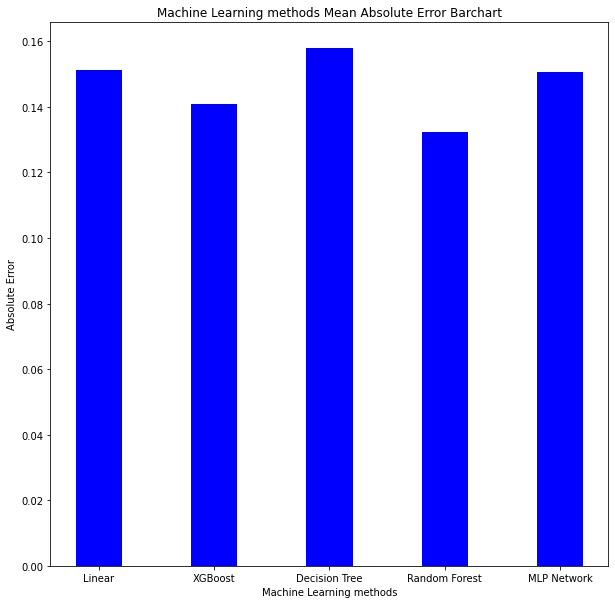

In [51]:
fig = plt.figure(figsize = (10, 10))
 
 
# creating the absolute error bar plot 
plt.bar( machinelearningmethodnames, abserrorval,color ='blue',
        width = 0.4)
 
plt.xlabel("Machine Learning methods")
plt.ylabel("Absolute Error")
plt.title("Machine Learning methods Mean Absolute Error Barchart")
plt.show()

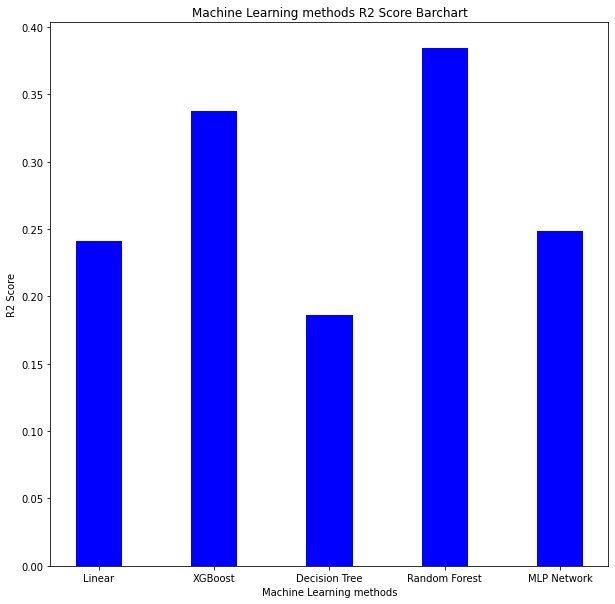

In [52]:
fig = plt.figure(figsize = (10, 10))
 
# creating the r2_score bar plot 
plt.bar( machinelearningmethodnames, r2scoreval,color ='blue',
        width = 0.4)
 

plt.xlabel("Machine Learning methods")
plt.ylabel("R2 Score")
plt.title("Machine Learning methods R2 Score Barchart")
plt.show()

* Now I am going to plot the feature importances of all the methods that can show us their feature importance

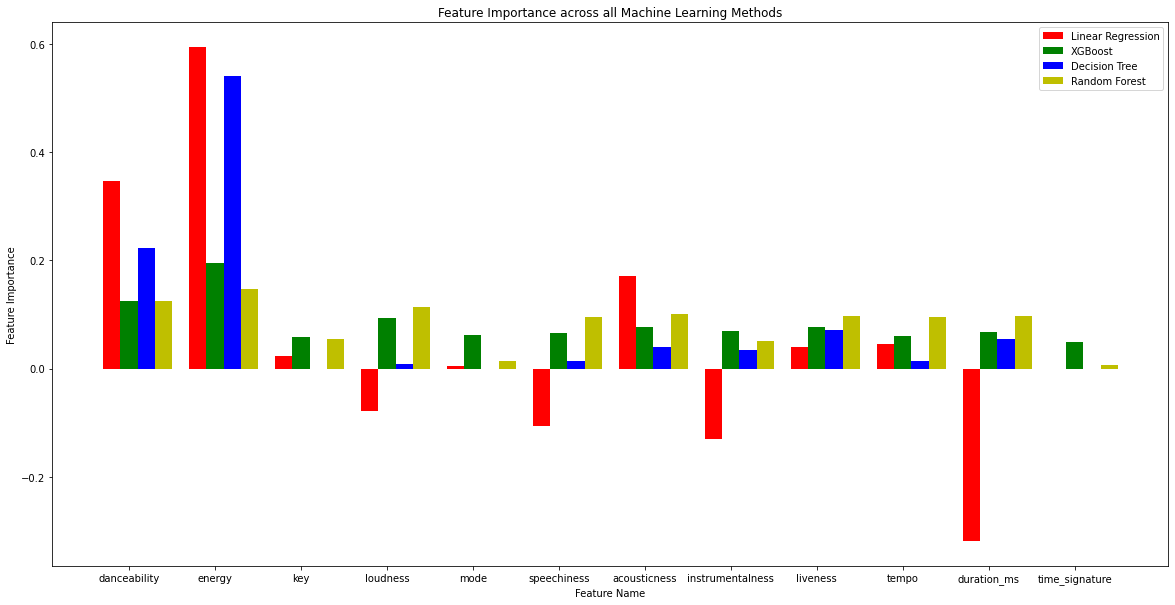

In [53]:
fig = plt.figure(figsize = (20, 10))
N=12 #Number of features
ind = np.arange(N) 
width = 0.20

barlinear = plt.bar(ind, importancelinear, width, color = 'r')
  

barxgb = plt.bar(ind+width, importancexgb, width, color='g')
  

bardt = plt.bar(ind+width*2, importancedt, width, color = 'b')


barrf = plt.bar(ind+width*3, importancerf, width, color = 'y')

plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.title("Feature Importance across all Machine Learning Methods")

plt.xticks(ind+width, feature_names)
plt.legend((barlinear,barxgb,bardt,barrf),('Linear Regression','XGBoost','Decision Tree','Random Forest'))
plt.show()

### Conculsion

After using inferential statistic methods and Machine learning methods we can reach a conclusion about the features that severely impact the valence variable:

* The two variables that are across all methods(statistical and machine learning) consistenly impactful are Danceability and Energy

* This is especially evident in the Random Forest Regressor method, which yields the best results

Comparison of best non connectivist approach with neural network approach:

* The best methods that we have are the Random Forest Regressor, the XGBoost and the MLP network

* Compared to the best non connectivist approaches the neural network is a bit better than the XGBoost method and a little bit worse than the Random Forest Regressor

* Nonetheless, no method is really good at predicting the valence dependent variable

LETS TEST THE TEST DATASET ON THE BEST METHOD THAT WE HAVE WHICH IS RANDOM FOREST REGRESSOR:

* I am going to load the songs that we are going to test on our test dataset

In [54]:
songs = pd.read_csv('spotify_ids.txt', header=None)
songs = songs.iloc[:,0]
test_data = pd.DataFrame()
for song in songs:
    test_data = test_data.append(sp.audio_features(song))
test_data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4
0,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
0,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
0,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,audio_features,4MzXwWMhyBbmu6hOcLVD49,spotify:track:4MzXwWMhyBbmu6hOcLVD49,https://api.spotify.com/v1/tracks/4MzXwWMhyBbm...,https://api.spotify.com/v1/audio-analysis/4MzX...,205090,4
0,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,audio_features,5Kskr9LcNYa0tpt5f0ZEJx,spotify:track:5Kskr9LcNYa0tpt5f0ZEJx,https://api.spotify.com/v1/tracks/5Kskr9LcNYa0...,https://api.spotify.com/v1/audio-analysis/5Ksk...,205458,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.596,0.650,9,-5.167,1,0.3370,0.13800,0.000000,0.1400,0.188,133.997,audio_features,4lUmnwRybYH7mMzf16xB0y,spotify:track:4lUmnwRybYH7mMzf16xB0y,https://api.spotify.com/v1/tracks/4lUmnwRybYH7...,https://api.spotify.com/v1/audio-analysis/4lUm...,257428,4
0,0.588,0.850,4,-6.431,1,0.0318,0.16800,0.002020,0.0465,0.768,93.003,audio_features,1fzf9Aad4y1RWrmwosAK5y,spotify:track:1fzf9Aad4y1RWrmwosAK5y,https://api.spotify.com/v1/tracks/1fzf9Aad4y1R...,https://api.spotify.com/v1/audio-analysis/1fzf...,187310,4
0,0.754,0.660,0,-6.811,1,0.2670,0.17900,0.000000,0.1940,0.316,83.000,audio_features,3E3pb3qH11iny6TFDJvsg5,spotify:track:3E3pb3qH11iny6TFDJvsg5,https://api.spotify.com/v1/tracks/3E3pb3qH11in...,https://api.spotify.com/v1/audio-analysis/3E3p...,209299,4
0,0.584,0.836,0,-4.925,1,0.0790,0.05580,0.000000,0.0663,0.484,104.973,audio_features,3yTkoTuiKRGL2VAlQd7xsC,spotify:track:3yTkoTuiKRGL2VAlQd7xsC,https://api.spotify.com/v1/tracks/3yTkoTuiKRGL...,https://api.spotify.com/v1/audio-analysis/3yTk...,202204,4


* I am going to keep only the features that we need and place the independent variables on the X dataframe and the valence in the y dataframe

* Then I am going to scale the independent variables

In [55]:
audio_feats = test_data[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','tempo','duration_ms','time_signature','valence']].copy()

X = audio_feats[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','tempo','duration_ms','time_signature']]
y = audio_feats['valence']

X = minmax.fit_transform(X)


* Now I am going to check how the RandomForestRegressor method performs on the test dataset

In [56]:
y_pred = bestmodelrf.predict(X)
score = r2_score(y,y_pred)
print(score)


0.32610984232122286


In [57]:
error = mean_absolute_error(y,y_pred)
print(error)

0.15733954130808947


We see that the mean absolute error got 0.02 worse in the test dataset

* Here are the important features of RandomForestRegressor

* The most impactful ones are the energy and danceability variables

Feature: danceability, Score: 0.12522
Feature: energy, Score: 0.14697
Feature: key, Score: 0.05471
Feature: loudness, Score: 0.11326
Feature: mode, Score: 0.01478
Feature: speechiness, Score: 0.09533
Feature: acousticness, Score: 0.10098
Feature: instrumentalness, Score: 0.05030
Feature: liveness, Score: 0.09774
Feature: tempo, Score: 0.09538
Feature: duration_ms, Score: 0.09797
Feature: time_signature, Score: 0.00736


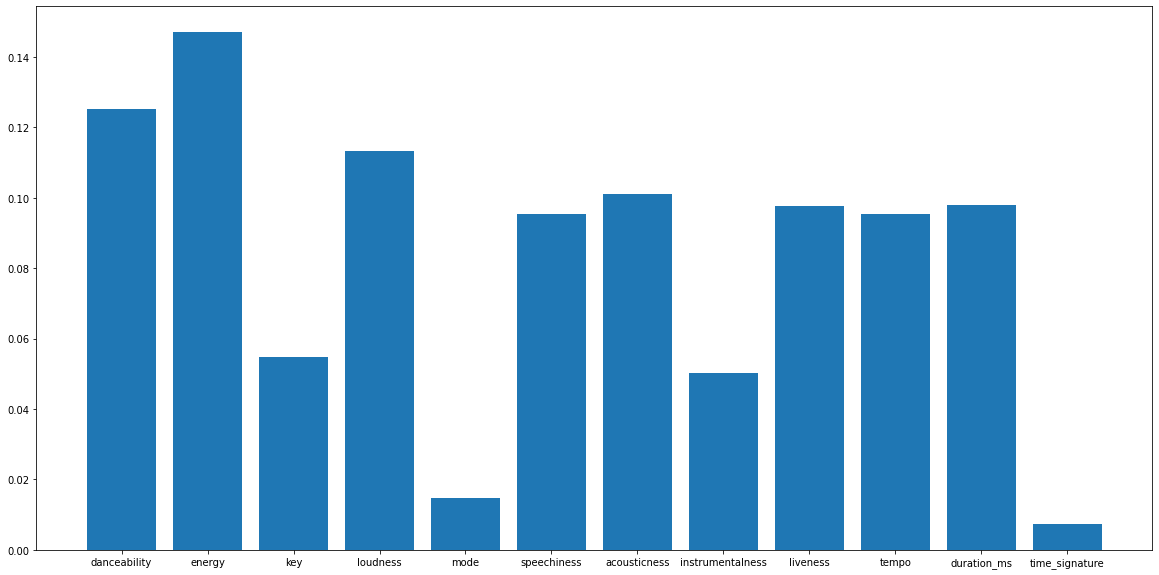

In [58]:
importancerf = bestmodelrf.feature_importances_
# summarize feature importance
for i,v in enumerate(importancerf):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
fig = plt.figure(figsize = (20, 10))
plt.bar(feature_names, importancerf)
plt.show()